In [5]:
print("All okay!")

All okay!


## First WorkFlow (Supervisor)

In [6]:
import sys, os

print(os.getcwd())

project_root = os.path.abspath(os.path.join(os.getcwd(),'..'))

d:\UV Projects\agentic-research-assistant\notebook


In [7]:
project_root

'd:\\UV Projects\\agentic-research-assistant'

In [8]:
sys.path.append(project_root)

In [9]:
from research_and_analyst.utils.model_loader import ModelLoader

In [10]:
model_loader = ModelLoader()

llm = model_loader.load_llm()

{"timestamp": "2026-01-04T05:58:22.046661Z", "level": "info", "event": "Initializing ApiKeyManager"}
{"timestamp": "2026-01-04T05:58:22.047470Z", "level": "warning", "event": "OPENAI_API_KEY is missing in environment variables"}
{"timestamp": "2026-01-04T05:58:22.047470Z", "level": "info", "event": "GOOGLE_API_KEY loaded successfully from environment"}
{"timestamp": "2026-01-04T05:58:22.047470Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"path": "D:\\UV Projects\\agentic-research-assistant\\research_and_analyst\\config\\configuration.yaml", "keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-01-04T05:58:22.070946Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-01-04T05:58:22.070946Z", "level": "info", "event": "YAML configuration loaded successfully"}
{"provider": "groq", "model": "llama-3.3-70b-versatile", "timestamp": "2026-01-04T05:58:22

In [11]:
llm.invoke("Hi there!").content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [12]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [13]:
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver 

In [14]:
class Analyst(BaseModel):
    name: str = Field(description="")
    role: str = Field(description="")
    affiliation: str = Field(description="")
    description: str = Field(description="")
    
    @property
    def persona(self) -> str:
        return f"name: {self.name}\nrole: {self.role}\naffiliation: {self.affiliation}\ndescription: {self.description}"

In [15]:
class Perspectives(BaseModel):
        analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [16]:
Analyst(
    name="Aryan",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='Aryan', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [17]:
analyst = Analyst(
    name="Aryan Gupta",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [18]:
analyst.name

'Aryan Gupta'

In [19]:
analyst.description

'I am genai developer as well as mentor'

In [20]:
analyst.persona

'name: Aryan Gupta\nrole: genai eng\naffiliation: AI Research LAB\ndescription: I am genai developer as well as mentor'

In [21]:
class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts : List[Analyst]

In [22]:
state = GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

In [23]:
topic = state['topic']
print(topic)

finance


In [24]:
analyst_num = state.get('max_analysts')
print(analyst_num)

5


In [25]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [26]:
def create_analyst(state: GenerateAnalystsState):
    """It is creating my analyst
    """
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback',"")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    return {"analysts": analysts.analysts }

In [27]:
create_analyst(
    {'topic' : "Education",
    'max_analysts' : 2,
    'human_analyst_feedback' : "How do AI impact Learning?"}
)

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Rachel Kim', role='AI Education Specialist', affiliation='Harvard University', description="Expert in AI-assisted learning platforms and their impact on student outcomes, focusing on the theme of 'AI-enhanced Learning Experience'"),
  Analyst(name='Dr. Liam Chen', role='EdTech Researcher', affiliation='Stanford University', description="Researcher on the effects of AI on learning outcomes, specializing in the theme of 'AI-driven Personalized Education'")]}

In [28]:
def human_feedback(state: GenerateAnalystsState):
    pass

In [29]:
def should_continue(state: GenerateAnalystsState):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

In [30]:
builder = StateGraph(GenerateAnalystsState)

In [31]:
memory = MemorySaver()

In [32]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [33]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])


In [34]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

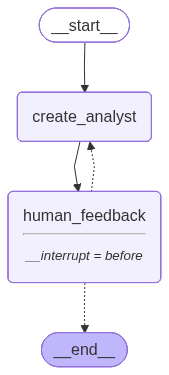

In [35]:
from IPython.display import display, Image

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
topic = "Why AI agents are more powerful than traditional AI chatbots?"

In [37]:
max_analysts = 3

In [38]:
thread = {"configurable":{"thread_id" : 1}}

In [40]:
for event in graph.stream(
    {"topic":topic,
        "max_analysts": max_analysts},
        thread,
        stream_mode='values',):
    
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Rachel Kim
Affiliation: Stanford University
Role: AI Researcher
Description: Expert in AI agents and their applications, with a focus on theme 1: Autonomous Decision Making
--------------------------------------------------
Name: Dr. Liam Chen
Affiliation: MIT
Role: AI Engineer
Description: Specialist in natural language processing and theme 2: Human-Computer Interaction
--------------------------------------------------
Name: Dr. Maya Patel
Affiliation: Harvard University
Role: Cognitive Scientist
Description: Authority on cognitive architectures and theme 3: Explainable AI
--------------------------------------------------


In [42]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'topic': 'Why AI agents are more powerful than traditional AI chatbots?', 'max_analysts': 3, 'analysts': [Analyst(name='Dr. Rachel Kim', role='AI Researcher', affiliation='Stanford University', description='Expert in AI agents and their applications, with a focus on theme 1: Autonomous Decision Making'), Analyst(name='Dr. Liam Chen', role='AI Engineer', affiliation='MIT', description='Specialist in natural language processing and theme 2: Human-Computer Interaction'), Analyst(name='Dr. Maya Patel', role='Cognitive Scientist', affiliation='Harvard University', description='Authority on cognitive architectures and theme 3: Explainable AI')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e9327-ef39-6da0-8001-78d34530d575'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-04T05:59:13.601680+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

In [43]:
state.values

{'topic': 'Why AI agents are more powerful than traditional AI chatbots?',
 'max_analysts': 3,
 'analysts': [Analyst(name='Dr. Rachel Kim', role='AI Researcher', affiliation='Stanford University', description='Expert in AI agents and their applications, with a focus on theme 1: Autonomous Decision Making'),
  Analyst(name='Dr. Liam Chen', role='AI Engineer', affiliation='MIT', description='Specialist in natural language processing and theme 2: Human-Computer Interaction'),
  Analyst(name='Dr. Maya Patel', role='Cognitive Scientist', affiliation='Harvard University', description='Authority on cognitive architectures and theme 3: Explainable AI')]}

In [44]:
state.next

('human_feedback',)

In [45]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e9327-ef39-6da0-8001-78d34530d575'}}

In [46]:
graph.update_state(thread,
                   {"human_analyst_feedback":"Focus on how it impacts enterprise applications."},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e932f-9617-63fe-8002-be9afc9fe559'}}

In [47]:
for event in graph.stream(
    {"topic":topic,
        "max_analysts": max_analysts},
        thread,
        stream_mode='values',):
    
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Rachel Kim
Affiliation: Stanford University
Role: AI Researcher
Description: Expert in AI agents and their applications, with a focus on theme 1: Autonomous Decision Making
--------------------------------------------------
Name: Dr. Liam Chen
Affiliation: MIT
Role: AI Engineer
Description: Specialist in natural language processing and theme 2: Human-Computer Interaction
--------------------------------------------------
Name: Dr. Maya Patel
Affiliation: Harvard University
Role: Cognitive Scientist
Description: Authority on cognitive architectures and theme 3: Explainable AI
--------------------------------------------------


HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Emily Chen
Affiliation: Stanford University
Role: AI Researcher
Description: Expert in AI agents and their applications in enterprise settings, focusing on theme 1: Enhanced Autonomy
--------------------------------------------------
Name: Ryan Thompson
Affiliation: Deloitte
Role: Enterprise Consultant
Description: Specialist in implementing AI solutions for businesses, focusing on theme 2: Improved Decision-Making
--------------------------------------------------
Name: Dr. Zara Saeed
Affiliation: Harvard University
Role: AI Ethicist
Description: Leading researcher on the ethical implications of AI agents in enterprise applications, focusing on theme 3: Increased Efficiency
--------------------------------------------------


In [54]:
state

StateSnapshot(values={'topic': 'Why AI agents are more powerful than traditional AI chatbots?', 'max_analysts': 3, 'analysts': [Analyst(name='Dr. Rachel Kim', role='AI Researcher', affiliation='Stanford University', description='Expert in AI agents and their applications, with a focus on theme 1: Autonomous Decision Making'), Analyst(name='Dr. Liam Chen', role='AI Engineer', affiliation='MIT', description='Specialist in natural language processing and theme 2: Human-Computer Interaction'), Analyst(name='Dr. Maya Patel', role='Cognitive Scientist', affiliation='Harvard University', description='Authority on cognitive architectures and theme 3: Explainable AI')]}, next=('human_feedback',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0e9327-ef39-6da0-8001-78d34530d575'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-04T05:59:13.601680+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

In [53]:
cfg = state.config

In [ ]:
graph.update_state(cfg,
                   {"human_analyst_feedback": "None" },as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e95d7-9c9f-6ae1-8007-1b5dc88fa7c7'}}

In [55]:
final_state = graph.get_state(thread)
final_state.next

()

In [56]:
analysts = final_state.values.get('analysts')

In [57]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Emily Chen
Affiliation: Stanford University
Role: AI Researcher
Description: Expert in AI agents and their applications in enterprise settings, focusing on theme 1: Enhanced Autonomy
--------------------------------------------------
Name: Ryan Thompson
Affiliation: Deloitte
Role: Enterprise Consultant
Description: Specialist in implementing AI solutions for businesses, focusing on theme 2: Improved Decision-Making
--------------------------------------------------
Name: Dr. Zara Saeed
Affiliation: Harvard University
Role: AI Ethicist
Description: Leading researcher on the ethical implications of AI agents in enterprise applications, focusing on theme 3: Increased Efficiency
--------------------------------------------------


## Second Workflow (Agents and Tool Calling)